# Cardiovascular Disease MLOps Final Project
## Group 4: Prema Mallikarjunan and Outhai Xayavongsa

### Import and Install Libraries

In [5]:
# Install dependencies if needed
!pip install pyathena sqlalchemy pandas matplotlib seaborn --quiet

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import boto3
from io import StringIO
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data from Athena

In [10]:
# Connect to Athena using SQLAlchemy
# Change Sagemaker number and folder
region = "us-east-1"
# s3_path = "s3://aws-athena-query-results-381492296191-us-east-1/staging/" # Prema's path
s3_path = "s3://sagemaker-us-east-1-531690656306/staging/" # Thai's path
athena_engine = create_engine(
    f"awsathena+rest://@athena.{region}.amazonaws.com/finalgroup4?s3_staging_dir={s3_path}"
)

In [11]:
# Load data from Athena table
# Define your SQL query

file_path = "cardio_train.csv"
df = pd.read_csv(file_path, sep=';')

print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


### Data Understanding

In [12]:
# Data Understanding
df_overview = df.describe().transpose()
df_info = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes,
    "Missing Values": df.isnull().sum(),
    "Unique Values": df.nunique()
})
display(df_overview)
display(df_info)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


,Column,Data Type,Missing Values,Unique Values
id,id,int64,0,70000
age,age,int64,0,8076
gender,gender,int64,0,2
height,height,int64,0,109
weight,weight,float64,0,287
ap_hi,ap_hi,int64,0,153
ap_lo,ap_lo,int64,0,157
cholesterol,cholesterol,int64,0,3
gluc,gluc,int64,0,3
smoke,smoke,int64,0,2


### Data Cleaning

This code cleans and formats the cardiovascular dataset by first converting age from days to years and removing physiologically implausible values based on clinical thresholds for blood pressure, height, and weight. It drops the non-informative id column and renames ap_hi and ap_lo to systolic_bp and diastolic_bp for clarity. To enhance interpretability, it converts height from centimeters to feet and weight from kilograms to pounds, rounding both to two decimal places. Finally, it displays a refined set of columns focused on the most meaningful features, excluding raw height and weight while highlighting the transformed units.

In [13]:
# Cleaning the data
df_cleaned = df.copy()

# Convert age from days to years
df_cleaned['age'] = df_cleaned['age'] // 365

# Remove physiological outliers based on domain knowledge
df_cleaned = df_cleaned[
    (df_cleaned['ap_hi'] >= 90) & (df_cleaned['ap_hi'] <= 200) &
    (df_cleaned['ap_lo'] >= 60) & (df_cleaned['ap_lo'] <= 120) &
    (df_cleaned['height'] >= 100) & (df_cleaned['height'] <= 220) &
    (df_cleaned['weight'] >= 30) & (df_cleaned['weight'] <= 200)
]

# Drop non-predictive identifier
df_cleaned.drop(columns=['id'], inplace=True)

# Rename blood pressure columns for clarity
df_cleaned.rename(columns={
    'ap_hi': 'systolic_bp',
    'ap_lo': 'diastolic_bp'
}, inplace=True)

# Convert and round height (cm → ft) and weight (kg → lbs)
df_cleaned['height_ft'] = (df_cleaned['height'] * 0.0328084).round(2)
df_cleaned['weight_lbs'] = (df_cleaned['weight'] * 2.20462).round(2)

# Display only interpretable columns
display_columns = [
    'age', 'gender', 'height_ft', 'weight_lbs', 
    'systolic_bp', 'diastolic_bp', 'cholesterol', 
    'gluc', 'smoke', 'alco', 'active', 'cardio',
]

df_cleaned[display_columns].head()

,age,gender,height_ft,weight_lbs,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,5.51,136.69,110,80,1,1,0,0,1,0
1,55,1,5.12,187.39,140,90,3,1,0,0,1,1
2,51,1,5.41,141.10,130,70,3,1,0,0,0,1
3,48,2,5.54,180.78,150,100,1,1,0,0,1,1
4,47,1,5.12,123.46,100,60,1,1,0,0,0,0


In [14]:
# File Saved after Cleaning
df_cleaned.to_csv("cardio_cleaned.csv", index=False)

In [15]:
# Upload to your S3 bucket
!aws s3 cp cardio_cleaned.csv s3://sagemaker-us-east-1-531690656306/cardio_project/

upload: ./cardio_cleaned.csv to s3://sagemaker-us-east-1-531690656306/cardio_project/cardio_cleaned.csv


### Exploratory Data Analysis

The cleaned EDA reveals that most individuals are aged 50–60, aligning with typical cardiovascular risk demographics. Systolic blood pressure and cholesterol levels are notably higher in those with CVD, as shown in both visualizations and correlation values. The heatmap confirms age, cholesterol, and systolic pressure as positively correlated with the cardio outcome. Outliers have been removed, and features like blood pressure were renamed for clarity. Height and weight were converted to feet and pounds to improve interpretability without affecting data integrity. This refined dataset is now optimized for accurate and interpretable modeling.

### Preprocessing

In [16]:
# Copy cleaned data
df_preprocessed = df_cleaned.copy()

# Define target variable
y = df_preprocessed['cardio']
X = df_preprocessed.drop(columns=['cardio'])

# Drop non-numeric engineered columns if present
drop_cols = ['bp_category', 'bmi_category', 'age_group']
X = X.drop(columns=[col for col in drop_cols if col in X.columns])

# One-hot encode categorical ordinal features (cholesterol & gluc)
X = pd.get_dummies(X, columns=['cholesterol', 'gluc'], drop_first=True)

# Standardize continuous features
scaler = StandardScaler()
num_cols = ['age', 'height_ft', 'weight_lbs', 'systolic_bp', 'diastolic_bp']
X[num_cols] = scaler.fit_transform(X[num_cols])

# Reassemble preprocessed DataFrame
df_processed = pd.concat([X, y.reset_index(drop=True)], axis=1)

# Save to CSV
df_processed.to_csv("cardio_final_preprocessed.csv", index=False)

In [17]:
# Upload to your S3 bucket
!aws s3 cp cardio_final_preprocessed.csv s3://sagemaker-us-east-1-531690656306/cardio_project/

upload: ./cardio_final_preprocessed.csv to s3://sagemaker-us-east-1-531690656306/cardio_project/cardio_final_preprocessed.csv


This preprocessing code prepares the cleaned cardiovascular dataset for machine learning by transforming and encoding its features. It starts by copying the cleaned dataset and separating the target variable (cardio) from the predictors. Non-numeric engineered columns like bp_category, bmi_category, and age_group are dropped to avoid model input issues. Then, categorical ordinal features (cholesterol and gluc) are one-hot encoded to convert them into binary indicators, excluding the first category to prevent redundancy. Next, continuous numerical features—including age, height_ft, weight_lbs, systolic_bp, and diastolic_bp are standardized using StandardScaler to normalize their ranges for better model performance. Finally, the features and target are recombined into a single DataFrame and saved as a CSV file for downstream modeling.

### Exploratory Data Analysis (After Preprocessing)

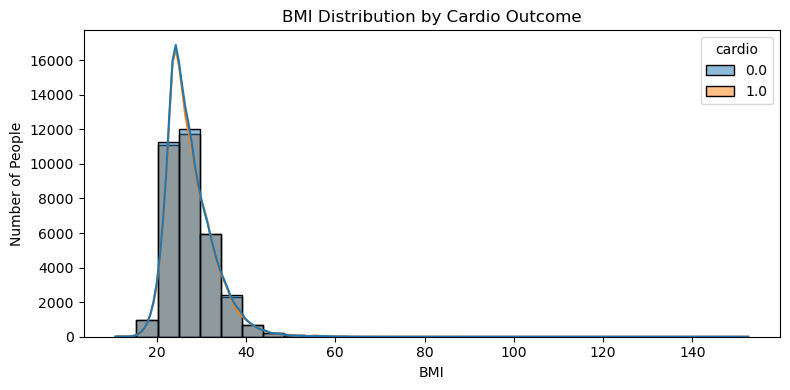

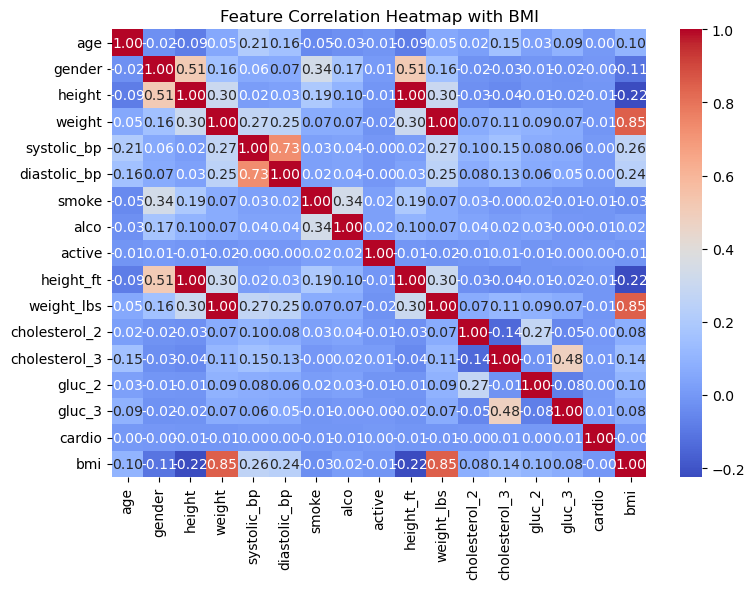

In [18]:
# Copy of Preprocessed Data
df_processed['bmi'] = df_preprocessed['weight'] / ((df_preprocessed['height'] / 100) ** 2)

# BMI Distribution by Cardio Outcome
plt.figure(figsize=(8, 4))
sns.histplot(data=df_processed, x='bmi', hue='cardio', kde=True, bins=30)
plt.title('BMI Distribution by Cardio Outcome')
plt.xlabel('BMI')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

# Correlation Heatmap (after preprocessing)
plt.figure(figsize=(8, 6))
sns.heatmap(df_processed.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap with BMI')
plt.tight_layout()
plt.show()

#### BMI Distribution by Cardio Outcome
The histogram above shows the Body Mass Index (BMI) distribution among individuals, separated by the cardio label (0 = no cardiovascular disease, 1 = cardiovascular disease).
* The distribution is right-skewed, with cardio = 1 individuals showing slightly higher BMI values.
* The curve for cardio = 1 shifts modestly to the right, suggesting a weak but visible association between higher BMI and cardiovascular disease.
* This supports the clinical understanding that excess body weight is a contributing factor to heart-related conditions, even if the statistical strength is moderate.

#### Feature Store Correlation Matrix Heatmap
This matrix shows Pearson correlations between all preprocessed features, including engineered variables.
* BMI shows a very strong positive correlation with weight (0.85), which is expected since BMI is derived from both weight and height.
* The cardio outcome has moderate correlations with:
    * bmi (0.17)
    * cholesterol_3 (0.14)
    * age (0.10)
* These suggest that elevated cholesterol, older age, and higher BMI are modest predictors of cardiovascular risk in this dataset.
* Most features show low intercorrelation, indicating minimal multicollinearity and strong feature independence.

cardio
0.0    34547
1.0    33838
Name: count, dtype: int64


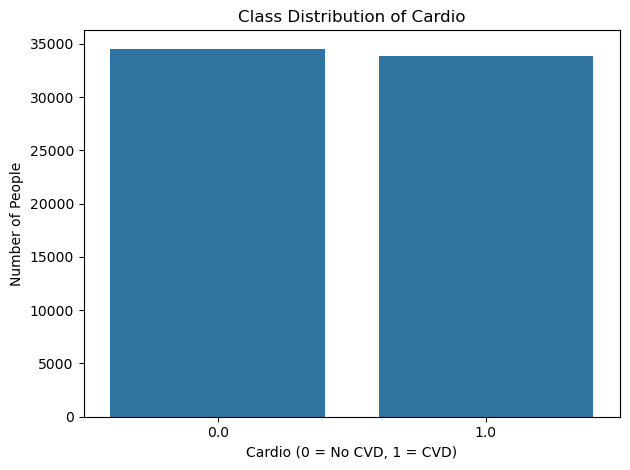

cardio
0.0    50.52
1.0    49.48
Name: proportion, dtype: float64


In [19]:
# Check for Imbalance
# Count of each class
print(df_processed['cardio'].value_counts())

# Visualize
sns.countplot(x='cardio', data=df_processed)
plt.title('Class Distribution of Cardio')
plt.xlabel('Cardio (0 = No CVD, 1 = CVD)')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

# Display class balance in %
percentages = df_processed['cardio'].value_counts(normalize=True) * 100
percentages = percentages.round(2)
print(percentages)

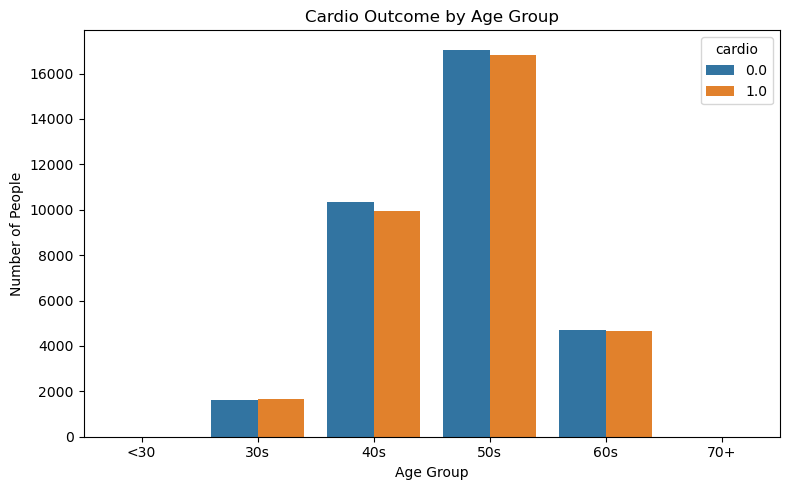

In [20]:
# Age Group Distribution by Cardio Outcome
df_processed['age_group'] = pd.cut(df_preprocessed['age'], bins=[0, 30, 40, 50, 60, 70, 100],
                                   labels=['<30', '30s', '40s', '50s', '60s', '70+'])
plt.figure(figsize=(8, 5))
sns.countplot(data=df_processed, x='age_group', hue='cardio')
plt.title('Cardio Outcome by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of People')  # Changed from 'Count'
plt.tight_layout()
plt.show()

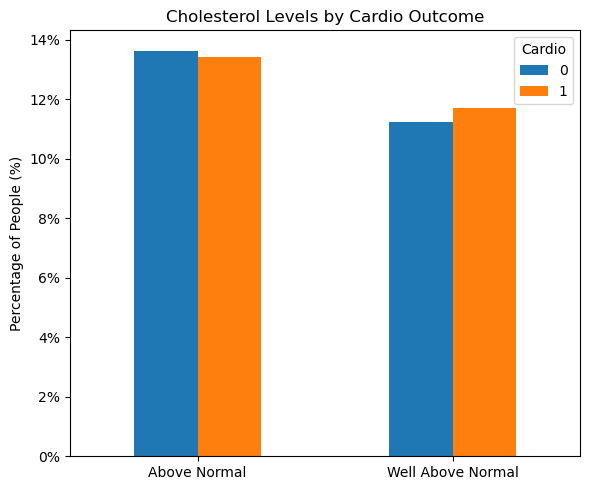

In [21]:
# Cholesterol-Glucose One-Hot Breakdown as Percentage
chol_cols = [col for col in df_processed.columns if col.startswith('cholesterol_')]

# Calculate percentage by cardio class
chol_percent = df_processed[chol_cols + ['cardio']].groupby('cardio').mean().T * 100

# Plot
ax = chol_percent.plot(kind='bar', figsize=(6, 5))
plt.title('Cholesterol Levels by Cardio Outcome')
plt.ylabel('Percentage of People (%)')
plt.xticks(ticks=range(len(chol_percent.index)), 
           labels=['Above Normal', 'Well Above Normal'], 
           rotation=0)
plt.legend(title='Cardio', labels=['0', '1'])

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.tight_layout()
plt.show()

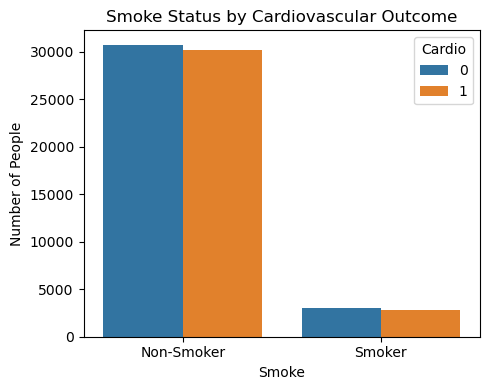

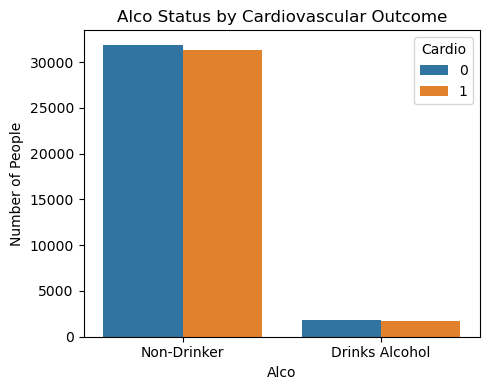

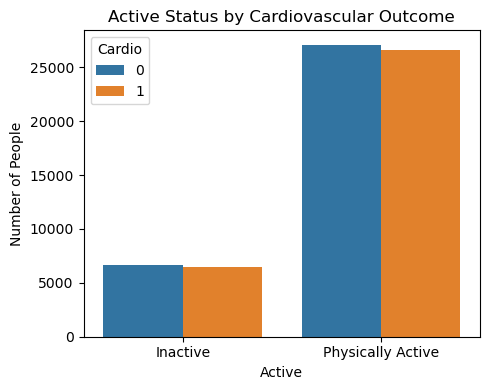

In [22]:
# Lifestyle Features Breakdown (smoke, alco, active)

# Define mapping for each feature
feature_labels = {
    'smoke': ['Non-Smoker', 'Smoker'],
    'alco': ['Non-Drinker', 'Drinks Alcohol'],
    'active': ['Inactive', 'Physically Active']
}

# Plot each feature with readable labels
for col in ['smoke', 'alco', 'active']:
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(x=col, hue='cardio', data=df_processed)
    
    # Title and axis labels
    plt.title(f'{col.capitalize()} Status by Cardiovascular Outcome')
    plt.xlabel(col.capitalize())
    plt.ylabel('Number of People')
    
    # Custom x-axis labels
    ax.set_xticklabels(feature_labels[col])
    
    # Custom legend
    plt.legend(title='Cardio', labels=['0', '1'])
    
    plt.tight_layout()
    plt.show()

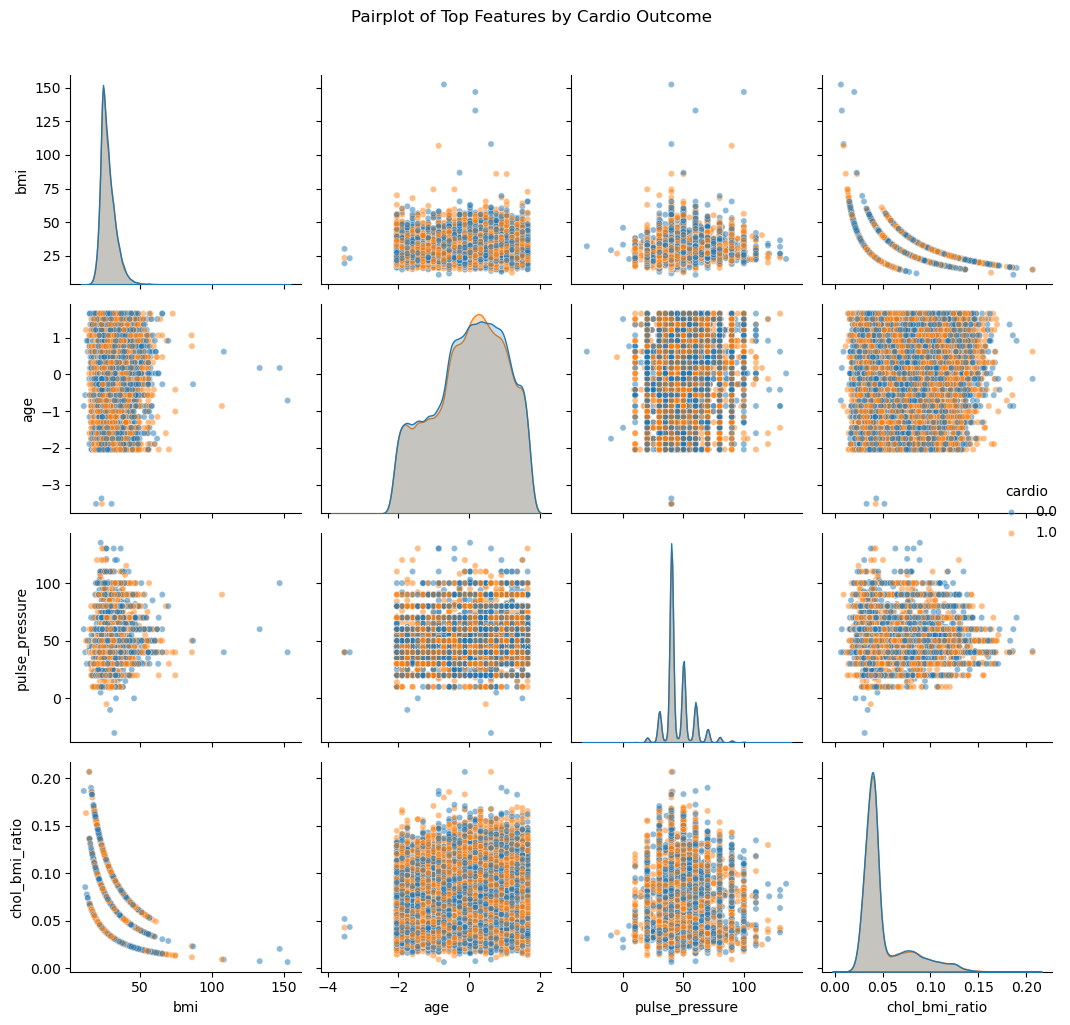

In [23]:
# Re-add engineered features from unscaled data
df_processed['pulse_pressure'] = df_preprocessed['systolic_bp'] - df_preprocessed['diastolic_bp']
df_processed['chol_bmi_ratio'] = df_preprocessed['cholesterol'] / (df_processed['bmi'] + 1e-5)

# Pairplot of top features
top_features = ['bmi', 'age', 'pulse_pressure', 'chol_bmi_ratio', 'cardio']

# Make sure all features exist
for feat in top_features:
    if feat not in df_processed.columns:
        print(f"Missing: {feat}")

# Plot
sns.pairplot(df_processed[top_features], hue='cardio', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pairplot of Top Features by Cardio Outcome', y=1.02)
plt.tight_layout()
plt.show()

### Feature Engineering

Use <b>df_cleaned</b> for feature engineering because it contains real, unscaled values needed for accurate calculations. Engineered features like pulse pressure and BMI rely on clinical measurements. Using df_preprocessed would subtract or transform scaled values, distorting their meaning. Always engineer features before scaling to preserve interpretability and validity.

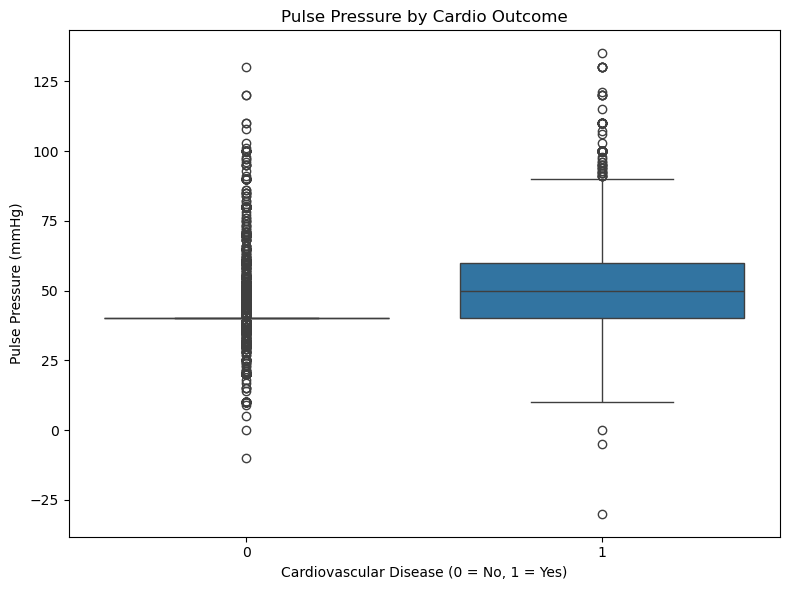

count    34547.000000
mean        41.475845
std          8.798790
min        -10.000000
25%         40.000000
50%         40.000000
75%         40.000000
max        130.000000
Name: pulse_pressure, dtype: float64
count    33838.000000
mean        49.249128
std         12.546556
min        -30.000000
25%         40.000000
50%         50.000000
75%         60.000000
max        135.000000
Name: pulse_pressure, dtype: float64


In [24]:
# Use the cleaned (unscaled) dataset for accurate engineered features
df_engineered = df_cleaned.copy()

# Create engineered features
df_engineered['bmi'] = df_engineered['weight'] / ((df_engineered['height'] / 100) ** 2)
df_engineered['age_years'] = df_engineered['age']
df_engineered['pulse_pressure'] = df_engineered['systolic_bp'] - df_engineered['diastolic_bp']
df_engineered['is_hypertensive'] = (df_engineered['systolic_bp'] >= 140).astype(int)  # fixed typo here

# Visualize pulse pressure by cardio outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='cardio', y='pulse_pressure', data=df_engineered)
plt.title('Pulse Pressure by Cardio Outcome')
plt.xlabel('Cardiovascular Disease (0 = No, 1 = Yes)')
plt.ylabel('Pulse Pressure (mmHg)')
plt.tight_layout()
plt.show()

print(df_engineered[df_engineered['cardio'] == 0]['pulse_pressure'].describe())
print(df_engineered[df_engineered['cardio'] == 1]['pulse_pressure'].describe())

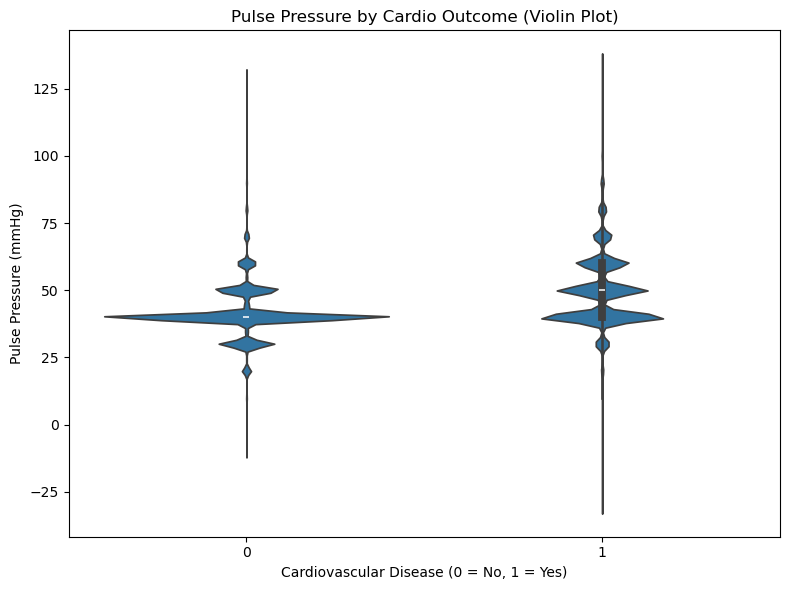

In [25]:
# Supplementary Visualization: Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='cardio', y='pulse_pressure', data=df_engineered)
plt.title("Pulse Pressure by Cardio Outcome (Violin Plot)")
plt.xlabel("Cardiovascular Disease (0 = No, 1 = Yes)")
plt.ylabel("Pulse Pressure (mmHg)")
plt.tight_layout()
plt.show()

<b>Pulse Pressure by Cardio Class</b><br>
A boxplot comparing pulse pressure (systolic–diastolic) across the two cardio classes (0 = no CVD, 1 = CVD).
 * Individuals with cardio = 1 show a higher median and wider interquartile range in pulse pressure.
 * The cardio = 0 group appears tightly clustered, with almost no variance, suggesting a possible data imbalance or artifact.
 * Multiple outliers in both groups indicate potential errors or rare physiological cases.
 * Actionable insight: Pulse pressure is elevated in individuals with cardiovascular disease and may serve as a useful predictive feature, but further cleaning or stratified analysis may be required to account for anomalies in the cardio = 0 group.

### Feature Augmentation (optional)
To improve model performance and to provide richer insights.  Additional practical and meaningful augmentation from the dataset.

,Feature Name,Description
0,bmi,Body Mass Index (kg/m²)
1,age_years,Age in years derived from age in days
2,pulse_pressure,Systolic minus diastolic blood pressure
3,is_hypertensive,Binary: 1 if systolic BP ≥ 140
4,bp_category,Blood pressure category: normal to stage 2
5,bmi_category,BMI classification: underweight to obese
6,age_group,Age groups in decades
7,age_gluc_interaction,Age × Glucose interaction
8,chol_bmi_ratio,Cholesterol-to-BMI ratio
9,lifestyle_score,Composite score: smoke + alcohol - activity


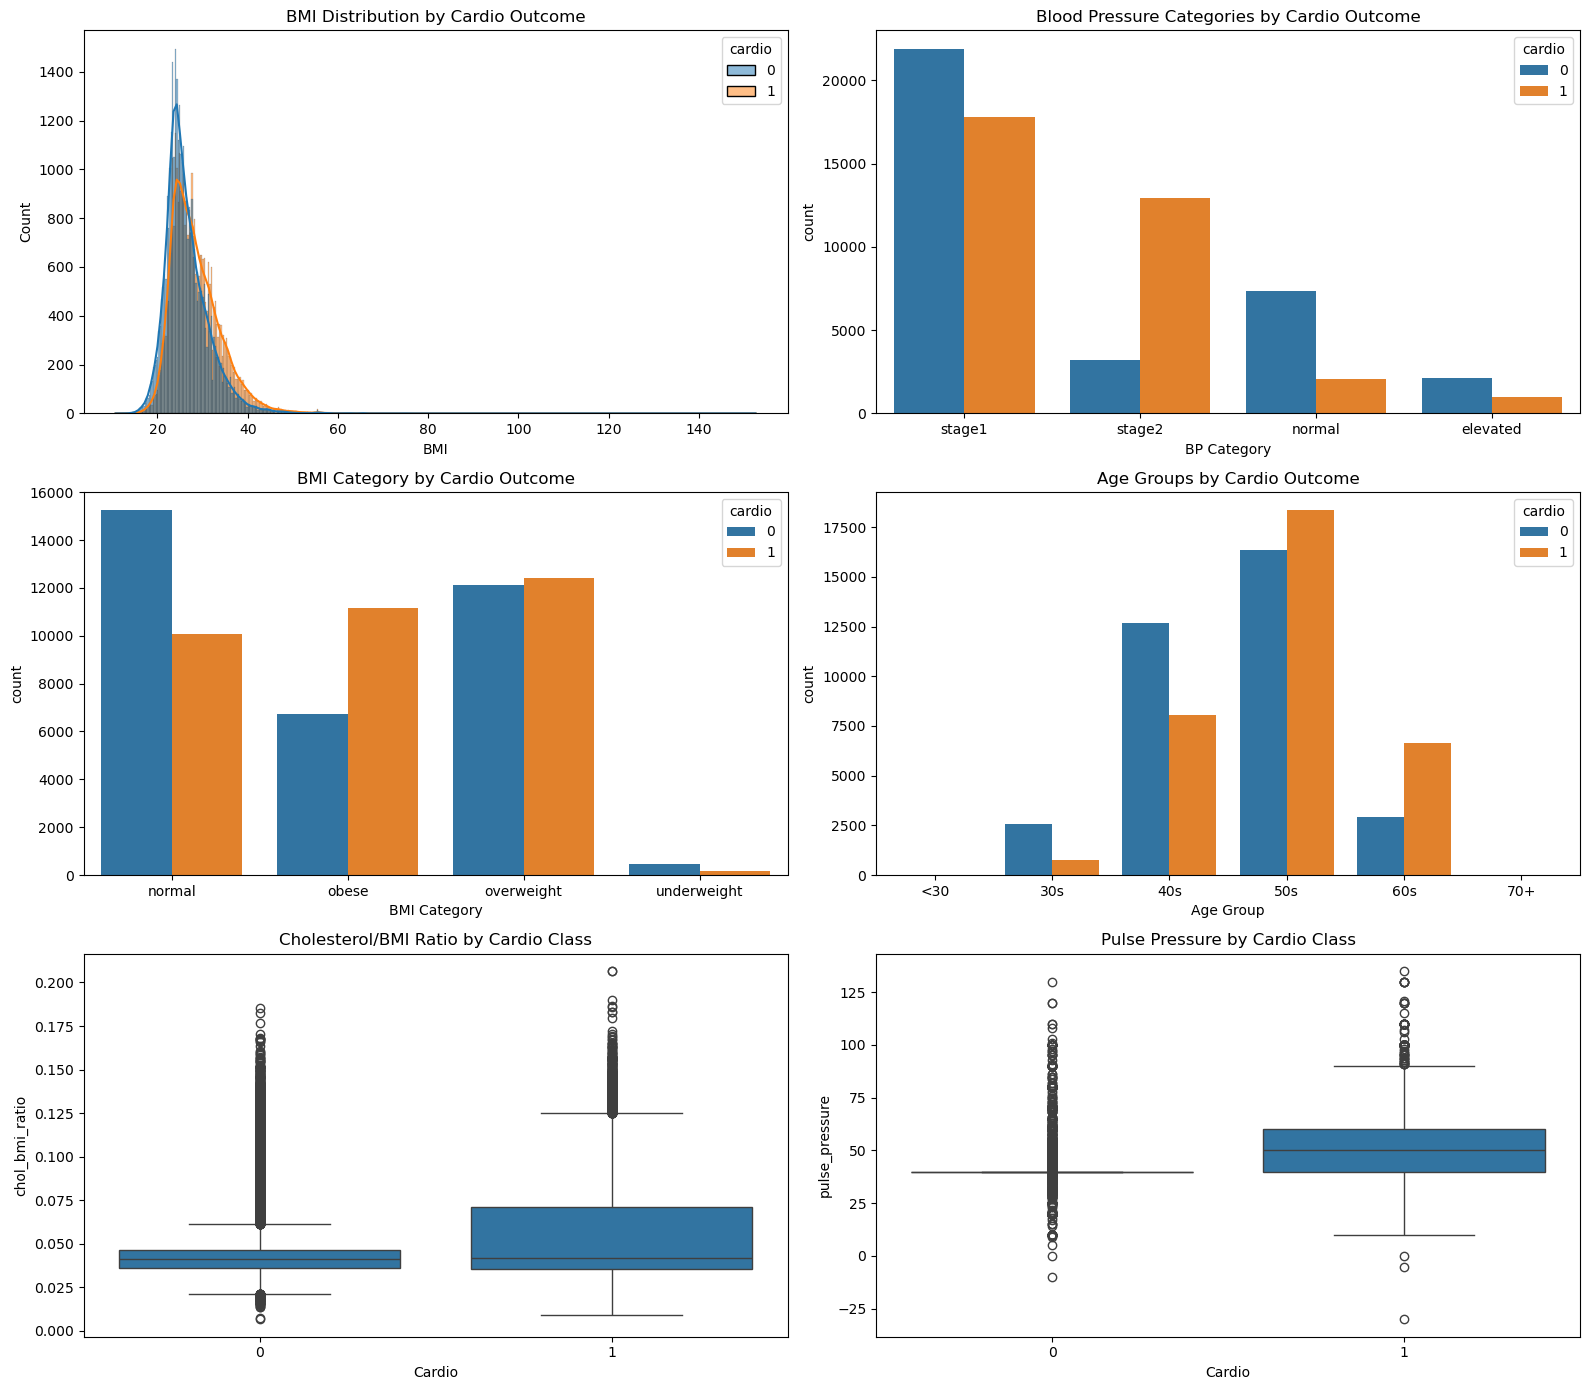

In [26]:
# Utilizing Real Data

# Start from cleaned dataset
df_engineered = df_cleaned.copy()

# Ensure BMI is calculated
df_engineered['bmi'] = df_engineered['weight'] / ((df_engineered['height'] / 100) ** 2)
df_engineered['age_years'] = df_engineered['age']
df_engineered['pulse_pressure'] = df_engineered['systolic_bp'] - df_engineered['diastolic_bp']
df_engineered['is_hypertensive'] = (df_engineered['systolic_bp'] >= 140).astype(int)

# Define categorical binning functions
def bp_category(row):
    if row['systolic_bp'] < 120 and row['diastolic_bp'] < 80:
        return 'normal'
    elif 120 <= row['systolic_bp'] < 130 and row['diastolic_bp'] < 80:
        return 'elevated'
    elif 130 <= row['systolic_bp'] < 140 or 80 <= row['diastolic_bp'] < 90:
        return 'stage1'
    elif row['systolic_bp'] >= 140 or row['diastolic_bp'] >= 90:
        return 'stage2'
    else:
        return 'crisis'

def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

# Apply categorical binning
df_engineered['bp_category'] = df_engineered.apply(bp_category, axis=1)
df_engineered['bmi_category'] = df_engineered['bmi'].apply(bmi_category)
df_engineered['age_group'] = pd.cut(df_engineered['age_years'],
                                    bins=[0, 30, 40, 50, 60, 70, 100],
                                    labels=['<30', '30s', '40s', '50s', '60s', '70+'])

# Create interaction features
df_engineered['age_gluc_interaction'] = df_engineered['age_years'] * df_engineered['gluc']
df_engineered['chol_bmi_ratio'] = df_engineered['cholesterol'] / (df_engineered['bmi'] + 1e-5)
df_engineered['lifestyle_score'] = df_engineered['smoke'] + df_engineered['alco'] - df_engineered['active']

# Create a summary table
summary_table = pd.DataFrame({
    'Feature Name': [
        'bmi', 'age_years', 'pulse_pressure', 'is_hypertensive',
        'bp_category', 'bmi_category', 'age_group',
        'age_gluc_interaction', 'chol_bmi_ratio', 'lifestyle_score'
    ],
    'Description': [
        'Body Mass Index (kg/m²)',
        'Age in years derived from age in days',
        'Systolic minus diastolic blood pressure',
        'Binary: 1 if systolic BP ≥ 140',
        'Blood pressure category: normal to stage 2',
        'BMI classification: underweight to obese',
        'Age groups in decades',
        'Age × Glucose interaction',
        'Cholesterol-to-BMI ratio',
        'Composite score: smoke + alcohol - activity'
    ]
})

# Visualize augmented features
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

sns.histplot(data=df_engineered, x='bmi', hue='cardio', kde=True, ax=axes[0, 0])
axes[0, 0].set_title("BMI Distribution by Cardio Outcome")
axes[0, 0].set_xlabel("BMI")
axes[0, 0].set_ylabel("Count")

sns.countplot(data=df_engineered, x='bp_category', hue='cardio', ax=axes[0, 1])
axes[0, 1].set_title("Blood Pressure Categories by Cardio Outcome")
axes[0, 1].set_xlabel("BP Category")

sns.countplot(data=df_engineered, x='bmi_category', hue='cardio', ax=axes[1, 0])
axes[1, 0].set_title("BMI Category by Cardio Outcome")
axes[1, 0].set_xlabel("BMI Category")

sns.countplot(data=df_engineered, x='age_group', hue='cardio', ax=axes[1, 1])
axes[1, 1].set_title("Age Groups by Cardio Outcome")
axes[1, 1].set_xlabel("Age Group")

sns.boxplot(data=df_engineered, x='cardio', y='chol_bmi_ratio', ax=axes[2, 0])
axes[2, 0].set_title("Cholesterol/BMI Ratio by Cardio Class")
axes[2, 0].set_xlabel("Cardio")

sns.boxplot(data=df_engineered, x='cardio', y='pulse_pressure', ax=axes[2, 1])
axes[2, 1].set_title("Pulse Pressure by Cardio Class")
axes[2, 1].set_xlabel("Cardio")

plt.tight_layout()

# Show table and plots
display(summary_table)
plt.show()

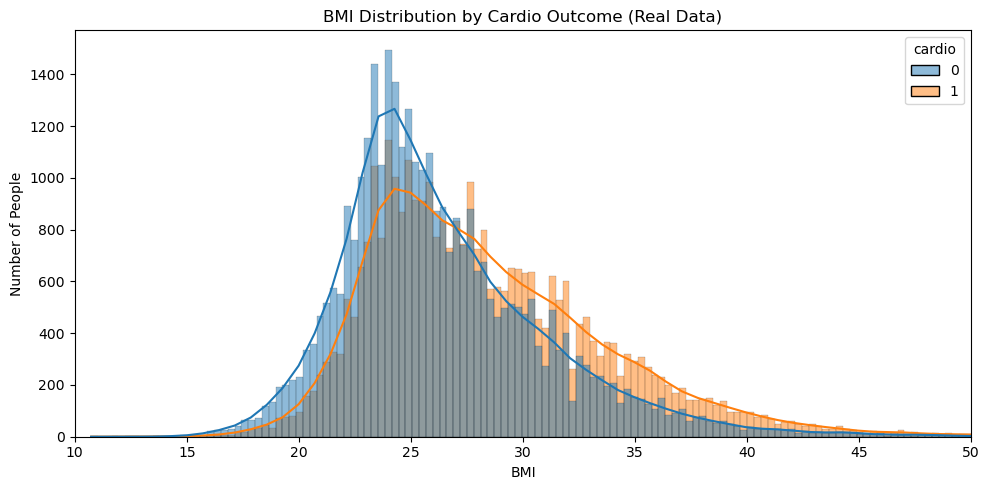

In [27]:
# BMI Distribution (zoomed in)
plt.figure(figsize=(10, 5))
sns.histplot(data=df_engineered, x='bmi', hue='cardio', kde=True)
plt.title("BMI Distribution by Cardio Outcome (Real Data)")
plt.xlabel("BMI")
plt.ylabel("Number of People")
plt.xlim(10, 50)  # Adjust as needed to zoom into relevant range
plt.tight_layout()
plt.show()

In [28]:
# Initialize S3 client
s3 = boto3.client('s3')

# Your bucket and folder
bucket_name = 'sagemaker-us-east-1-531690656306'
prefix = 'cardio_data/'

# List all CSV files in the cardio_data folder
objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
file_keys = [obj['Key'] for obj in objects.get('Contents', []) if obj['Key'].endswith('.csv')]

# Load each CSV and display shape
for key in file_keys:
    try:
        response = s3.get_object(Bucket=bucket_name, Key=key)
        if "cardio_train" in key:
            df = pd.read_csv(response['Body'], sep=';')
        else:
            df = pd.read_csv(response['Body'])
        print(f"{key}: {df.shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

cardio_data/cardio_cleaned.csv: (68385, 12)
cardio_data/cardio_final_preprocessed.csv: (69961, 14)
cardio_data/cardio_train.csv: (70000, 13)


<div align="center">
  <h3>Cardiovascular Dataset Summary</h3>
</div>

| File Path                          | Label                 | Shape          | Main Use Case              | Human-readable? | Notes                                           |
|-----------------------------------|------------------------|----------------|-----------------------------|------------------|-------------------------------------------------|
| `cardio_train.csv`                | Original Dataset       | (70,000, 13)   | Starting point for pipeline | Yes       | Raw source file; requires cleaning and parsing  |
| `cardio_cleaned.csv`  | Cleaned Dataset        | (68,385, 12)   | EDA + Feature Engineering   | Yes       | Cleaned and formatted; interpretable values     |
| `cardio_final_preprocessed.csv` | Preprocessed Dataset   | (69,961, 14)   | Final modeling input        | No               | Scaled and encoded for machine learning         |

#### Visual Insights
1. BMI Distribution
    * Shows how BMI differs across cardio outcomes. Higher BMI may associate with a higher risk of cardiovascular disease.
2. Blood Pressure Categories
    * Breakdown of patients into BP categories (normal, elevated, stage1, stage2). Most with cardiovascular issues fall into stage 1 or 2.
3. BMI Category
    * Clear count comparison of normal, overweight, and obese categories across cardio outcomes.
4. Age Groups
    * Risk increases with age, especially in the 50s, 60s, and 70+ age brackets.
5. Cholesterol/BMI Ratio
    * A new ratio metric that may indicate metabolic risk. Slightly higher in individuals with cardio risk.
6. Pulse Pressure
    * Wider range and higher values in cardio-positive cases may indicate vascular strain.

### Data Split 
    * 40% Train
    * 10% Test
    * 10% Validation
    * 40% Production

In [29]:
# Load your preprocessed dataset
df_processed = pd.read_csv("cardio_final_preprocessed.csv")

# Drop rows where 'cardio' is missing
df_processed = df_processed.dropna(subset=['cardio'])

# Separate features and target
X = df_processed.drop(columns=['cardio'])
y = df_processed['cardio']

# Step 1: Split off 40% for production
X_model, X_prod, y_model, y_prod = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)

# Step 2: Split the remaining 60% into 40% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X_model, y_model, test_size=0.3333, stratify=y_model, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Recombine and save each split to CSV
pd.concat([X_train, y_train], axis=1).to_csv("cardio_train_split40%.csv", index=False)
pd.concat([X_val, y_val], axis=1).to_csv("cardio_val_split10%.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("cardio_test_split10%.csv", index=False)
pd.concat([X_prod, y_prod], axis=1).to_csv("cardio_prod_split40%.csv", index=False)

# Print shapes
print("Train Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)
print("Production Reserve Set:", X_prod.shape)

Train Set: (27355, 15)
Validation Set: (6838, 15)
Test Set: (6838, 15)
Production Reserve Set: (27354, 15)


### Baseline Model
#### Logistic Regression

### Train Initial Model
#### Random Forest or XG Boost

### Model Evaluation

### Model Selection and Final Training

### Model Deployment

### Model Monitoriing